# Population Receptive Field (PRF) Mapping

This notebook illustrates the steps that are part of the PRF fitting procedure.

## Stimulus, PRF, and BOLD prediction

The retinotopic-mapping videos are transformed to `(time, y, x)` numpy arrays. The PRF are arrays of the same shape, although they are constant across time. The predicted BOLD response for a given PRF is the stimulus video multiplied by the PRF, and then convolved with the HRF.

In [1]:
from matplotlib import pyplot as plt
from forrestprf import stimulus, predictions

stim64 = stimulus.retinotopic_mapping_stim(64)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('One stimulus frame downsampled 64×')
plt.imshow(stim64[2])
plt.subplot(222)
plt.title('An example PRF')
plt.imshow(predictions.prf(4, 12, .5, stim64.shape)[0])
plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.title('Predicted bold response for example PRF')
plt.plot(
    predictions.bold_prediction(4, 12, .5, stim64, hrf=False),
    color='green', label='Without HRF'
)
plt.plot(
    predictions.bold_prediction(4, 12, .5, stim64, hrf=True),
    color='red', label='With HRF'
)
plt.legend()
plt.show()

Prediction cache: ../inputs/bold-predictions/{w}-{h}/{l}-{x}-{y}-{sd}.npy


<Figure size 1200x800 with 3 Axes>

## PRF mapping for V1

Load the retinotopic-mapping stimulus, the subject data, and a mask for the occipital cortex.

In [2]:
from forrestprf import data, stimulus

print('Load stimulus')
stim = stimulus.retinotopic_mapping_stim(4)
print('Load subject data')
bold = data.subject_data(1)
print('Load subject mask')
mask = data.juelich_mask(data.ROI_JUELICH['V1'])

Load stimulus
Load subject data
Load subject mask


Then we perform the actual PRF mapping. This will take some time!

In [3]:
from forrestprf import fitting

pass3 = fitting.prf_map(stim, bold, mask, npass=3)

PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)


Visually inspect some good fitting bold traces.

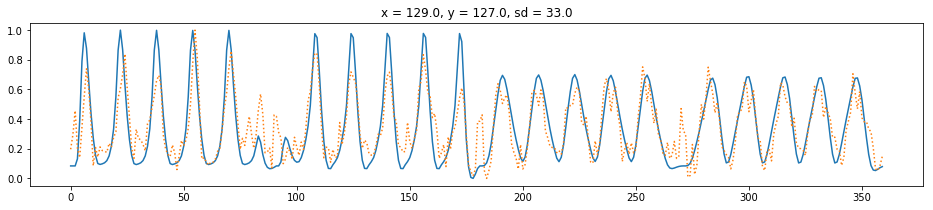

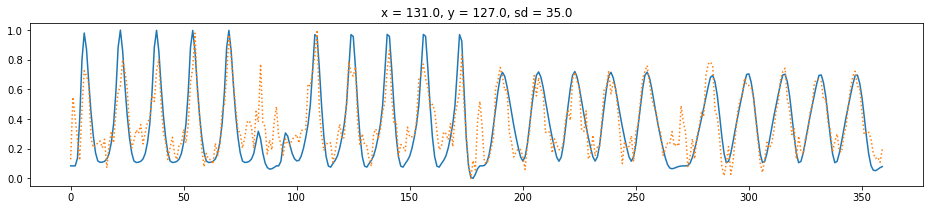

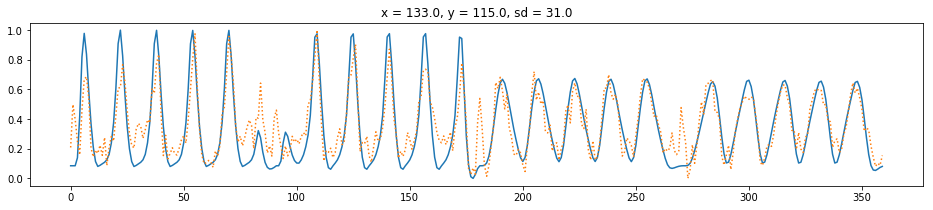

In [4]:
import numpy as np

MAX_ERR = 7

prf_err = pass3[0].prf_err.get_data()
prf_x = pass3[0].prf_x.get_data()
prf_y = pass3[0].prf_y.get_data()
prf_sd = pass3[0].prf_sd.get_data()
for x, y, z in zip(*np.where(prf_err < MAX_ERR)):
    e = prf_err[x, y, z]
    vox = bold.get_data()[x, y, z].copy()
    vox -= vox.min()
    vox /= vox.max()
    pred = predictions.bold_prediction(
        prf_x[x, y, z],
        prf_y[x, y, z],
        prf_sd[x, y, z],
        stim[:, ::2, ::2]
    )
    plt.figure(figsize=(16, 3))
    plt.title('x = {}, y = {}, sd = {}'.format(
        prf_x[x, y, z],
        prf_y[x, y, z],
        prf_sd[x, y, z]
    ))
    plt.plot(pred)
    plt.plot(vox, ':')
    plt.show()


## Inspect horizontal PRF position

In [5]:
from nilearn import plotting as nip, image

nft = image.copy_img(pass3[0].prf_x)
a = nft.get_data()
a -= 80
nip.view_img(nft)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:543: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:121: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error f